In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir ="/content/gdrive/MyDrive/dataset/photos"


In [ ]:
import pathlib                        #We have used pathlib in data directory so that we are able to use glob and you can 
data_dir = pathlib.Path(data_dir)      #already see the advantages of glob, when we use pathlib we see tha it is a Windows path 
data_dir                             #We converted our directory to windows pathlib directory

PosixPath('/content/gdrive/MyDrive/dataset/photos')

In [ ]:
alzheimer_images_dict = {                                    #here we have created a dictionary, if we do 
    'mild': list(data_dir.glob('MildDemented/*')),           #alzheimer_images_dict[MildDemented] we get all paths of 
    'moderate': list(data_dir.glob('ModerateDemented/*')),   #milddemented
    'no': list(data_dir.glob('NonDemented/*')),
    'verymild': list(data_dir.glob('VeryMildDemented/*')),
  
}

In [ ]:
alzheimer_labels_dict = {   #here I am assigning labels to each of the  classes
    'mild': 0,
    'moderate': 1,
    'no': 2,
    'verymild': 3,
    
}

In [ ]:
X, y = [], []

for alzheimer_name, images in alzheimer_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(alzheimer_labels_dict[alzheimer_name])
print(X[0].shape)  

(224, 224, 3)


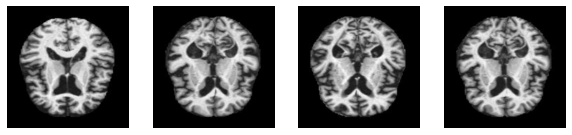

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (4288, 224, 224, 3)
X_test Shape:  (2112, 224, 224, 3)
y_train Shape:  (4288, 4)
y_test Shape:  (2112, 4)


In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224 


vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))  #where ever false is there means that they are not going  to trained 
                                                        #again as they are alredy being trained
# Here we freeze the top 4 layers 
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

58900480/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
num_classes = 4
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""                      #here I adding extra additional layers that will be helpful 
                                                              #in my program.
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)  n                   #here you can see I am passing vgg and number of classes to the lw func and lw bottom model
                                                      #will be vgg
model = Model(inputs = vgg.input, outputs = FC_Head)


In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                  
                  
  These are the layers that we have added to our model
  
  dense_3 (Dense)             (None, 4)  the final output layer in which the number of classes are 4

In [ ]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=24,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/24
134/134 [==============================] - 3204s 24s/step - loss: 1.3499 - accuracy: 0.5210 - val_loss: 0.8868 - val_accuracy: 0.5914
Epoch 2/24
134/134 [==============================] - 3198s 24s/step - loss: 0.8405 - accuracy: 0.6089 - val_loss: 0.8810 - val_accuracy: 0.5857
Epoch 3/24
134/134 [==============================] - 3201s 24s/step - loss: 0.7580 - accuracy: 0.6458 - val_loss: 0.7883 - val_accuracy: 0.6444
Epoch 4/24
134/134 [==============================] - 3201s 24s/step - loss: 0.6820 - accuracy: 0.6891 - val_loss: 0.6693 - val_accuracy: 0.7164
Epoch 5/24
134/134 [==============================] - 3208s 24s/step - loss: 0.6062 - accuracy: 0.7281 - val_loss: 0.7015 - val_accuracy: 0.6861
Epoch 6/24
134/134 [==============================] - 3200s 24s/step - loss: 0.5261 - accuracy: 0.7794 - val_loss: 0.6430 - val_accuracy: 0.7296
Epoch 7/24
134/134 [==============================] - 3204s 24s/step - loss: 0.4734 - accuracy: 0.7969 - val_loss: 0.6378 - val_ac

In [ ]:
model.save('vgg16alzheimer2')

INFO:tensorflow:Assets written to: vgg16alzheimer2/assets


In [ ]:
from keras.models import load_model

In [ ]:
new_model=load_model('vgg16alzheimer2')

In [ ]:
new_model.evaluate(X_test,y_test)

66/66 [==============================] - 1082s 16s/step - loss: 0.4524 - accuracy: 0.8660


[0.4524477422237396, 0.8660038113594055]

In [ ]:
predictions = new_model.predict(X_test) #we get this array as we have used linear activation func at last
predictions

array([[7.4840727e-06, 3.5947966e-08, 9.9932504e-01, 6.6750951e-04],
       [3.4163484e-08, 4.5684342e-11, 9.9998629e-01, 1.3767780e-05],
       [9.4582792e-03, 7.3412998e-04, 4.9702935e-03, 9.8483735e-01],
       ...,
       [9.9908519e-01, 1.8854577e-08, 5.3041987e-04, 3.8433418e-04],
       [1.9280186e-07, 4.7561927e-10, 9.8351526e-01, 1.6484499e-02],
       [1.7284548e-01, 1.9883211e-05, 4.6358287e-01, 3.6355180e-01]],
      dtype=float32)

In [ ]:
score = tf.nn.softmax(predictions[0]) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.17491446, 0.17491315, 0.47514242, 0.17502993], dtype=float32)>

In [ ]:
np.argmax(score)

2

In [ ]:
score = tf.nn.softmax(predictions) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(2112, 4), dtype=float32, numpy=
array([[0.17491446, 0.17491315, 0.47514242, 0.17502993],
       [0.17487843, 0.17487842, 0.4753623 , 0.17488082],
       [0.17733616, 0.17579578, 0.17654204, 0.47032604],
       ...,
       [0.47506267, 0.17492573, 0.17501855, 0.174993  ],
       [0.17573275, 0.17573272, 0.46988097, 0.17865358],
       [0.22785263, 0.19168884, 0.30473313, 0.27572536]], dtype=float32)>

In [ ]:
new=[]
ind=[]
for i in range(0,len(score)):
    maximum=-1
    for j in range(0,len(score[i])):
        
        if score[i][j]>maximum:
            maximum=score[i][j]
            index=j
            
    ind.append(index)       
    
    

print(ind)

[2, 2, 3, 3, 0, 2, 3, 2, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 3, 0, 2, 0, 2, 2, 3, 3, 2, 2, 1, 2, 2, 3, 3, 3, 2, 3, 3, 0, 2, 2, 2, 2, 2, 0, 3, 3, 3, 0, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 3, 0, 3, 2, 3, 2, 0, 3, 3, 3, 0, 2, 2, 3, 3, 0, 2, 2, 2, 0, 3, 2, 3, 2, 2, 2, 0, 2, 3, 2, 3, 3, 3, 0, 2, 2, 3, 2, 2, 2, 0, 3, 0, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 0, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 3, 3, 2, 3, 3, 3, 0, 2, 2, 2, 2, 3, 3, 2, 0, 0, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 0, 0, 0, 2, 3, 0, 3, 3, 3, 3, 3, 2, 0, 3, 3, 2, 3, 3, 3, 0, 0, 2, 2, 3, 3, 2, 0, 0, 2, 2, 2, 3, 2, 2, 2, 0, 3, 0, 3, 3, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 3, 3, 2, 2, 3, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 3, 2, 2, 3, 2, 3, 0, 0, 3, 3, 2, 0, 3, 2, 2, 3, 0, 2, 3, 3, 2, 3, 2, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 0, 0, 

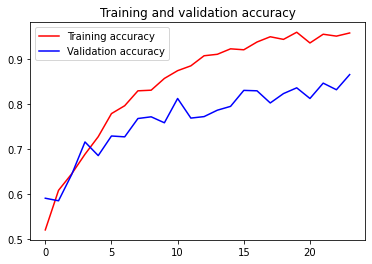

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test_labels=[np.argmax(i) for i in y_test]
y_test_labels[:5]

[2, 2, 3, 3, 0]

In [ ]:
X_test_labels=[np.argmax(i) for i in X_test]
X_test_labels[:5]

[56163, 72336, 60129, 64959, 111201]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from pylab import rcParams

In [ ]:
class_labels=["mild","moderate","no","verymild"]
  

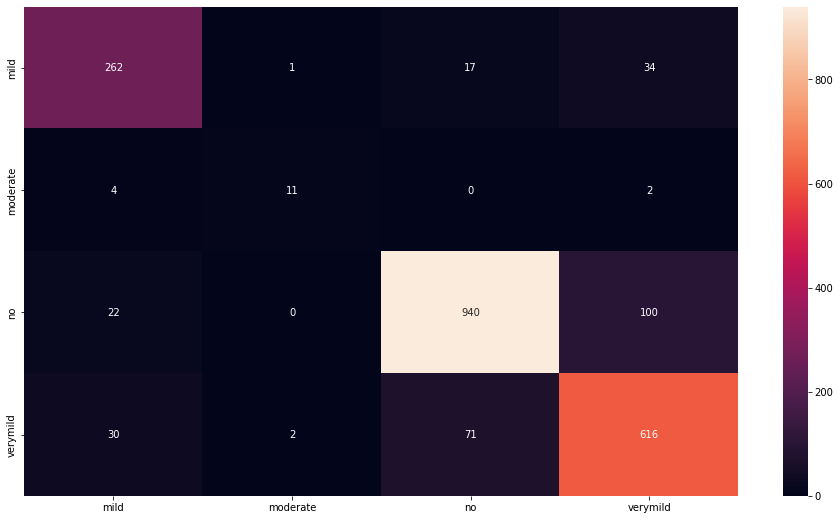

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,9))
cm=confusion_matrix(y_test_labels,ind)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)

In [ ]:
from sklearn.metrics import classification_report
cr=classification_report(y_test_labels,ind,target_names=class_labels)
print (cr)

              precision    recall  f1-score   support

        mild       0.82      0.83      0.83       314
    moderate       0.79      0.65      0.71        17
          no       0.91      0.89      0.90      1062
    verymild       0.82      0.86      0.84       719

    accuracy                           0.87      2112
   macro avg       0.84      0.81      0.82      2112
weighted avg       0.87      0.87      0.87      2112

